In [1]:
import sys, os
try:
    from google.colab import drive, userdata
    IS_COLAB = True
except ImportError:
    IS_COLAB = False

REPO_NAME = 'MistakeDetection'

if IS_COLAB:
    print("☁️ Colab rilevato.")
    if not os.path.exists('/content/drive'): drive.mount('/content/drive')

    GITHUB_USER = 'MarcoPernoVDP'
    try:
        TOKEN = userdata.get('GITHUB_TOKEN')
        REPO_URL = f'https://{TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git'
    except:
        REPO_URL = f'https://github.com/{GITHUB_USER}/{REPO_NAME}.git'

    ROOT_DIR = f'/content/{REPO_NAME}'
    if not os.path.exists(ROOT_DIR):
        !git clone {REPO_URL}
    else:
        %cd {ROOT_DIR}
        !git pull
        %cd /content


else:
    print("Ambiente locale rilevato.")
    ROOT_DIR = os.getcwd()
    while not os.path.exists(os.path.join(ROOT_DIR, '.gitignore')) and ROOT_DIR != os.path.dirname(ROOT_DIR):
        ROOT_DIR = os.path.dirname(ROOT_DIR)

if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)


☁️ Colab rilevato.
Mounted at /content/drive
Cloning into 'MistakeDetection'...
remote: Enumerating objects: 765, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 765 (delta 144), reused 106 (delta 51), pack-reused 533 (from 1)
Receiving objects: 100% (765/765), 86.55 MiB | 24.03 MiB/s, done.
Resolving deltas: 100% (416/416), done.


In [2]:
# Verifica ambiente
print(f"📍 Working directory: {ROOT_DIR}")
print(f"🐍 Python environment: {'Colab' if IS_COLAB else 'Local'}")

📍 Working directory: /content/MistakeDetection
🐍 Python environment: Colab


# Task 2 - Subtask 3: Hungarian Matching

Matching tra video step embeddings e task graph text embeddings usando l'algoritmo Ungherese.

## 1. Installazione Dipendenze

In [3]:
if IS_COLAB:
    !pip install scipy torch_geometric matplotlib seaborn -q

import numpy as np
import json
import zipfile
from pathlib import Path
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerie caricate")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00
✅ Librerie caricate


## 2. Configurazione Path

**Modifica questi path secondo la tua struttura:**

In [11]:
if IS_COLAB:
    # ========== CONFIGURA QUESTI PATH PER COLAB ==========
    VIDEO_FEATURES_PATH = "/content/drive/MyDrive/MistakeDetection/hiero_all_video_steps_max_steps_plus_1.npz"
    RECIPE_EMBEDDINGS_DIR = "/content/drive/MyDrive/MistakeDetection/recipe_text_step_embeddings"
    ANNOTATION_JSON_PATH = "/content/drive/MyDrive/MistakeDetection/annotation_json/complete_step_annotations.json"
    OUTPUT_DIR = "/content/drive/MyDrive/MistakeDetection/hungarian_results"
    # ====================================================
else:
    # ========== CONFIGURA QUESTI PATH PER LOCALE ==========
    VIDEO_FEATURES_PATH = str(Path(ROOT_DIR) / "data" / "hiero_all_video_steps.npz")
    RECIPE_EMBEDDINGS_DIR = str(Path(ROOT_DIR) / "data" / "recipe_text_step_embeddings")
    ANNOTATION_JSON_PATH = str(Path(ROOT_DIR) / "data" / "annotation_json" / "complete_step_annotations.json")
    OUTPUT_DIR = str(Path(ROOT_DIR) / "output" / "hungarian_results")
    # ====================================================

# Crea cartella output
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("📁 Configurazione:")
print(f"  Video features: {VIDEO_FEATURES_PATH}")
print(f"  Recipe embeddings dir: {RECIPE_EMBEDDINGS_DIR}")
print(f"  Annotation: {ANNOTATION_JSON_PATH}")
print(f"  Output directory: {OUTPUT_DIR}")

📁 Configurazione:
  Video features: /content/drive/MyDrive/MistakeDetection/hiero_all_video_steps_max_steps_plus_1.npz
  Recipe embeddings dir: /content/drive/MyDrive/MistakeDetection/recipe_text_step_embeddings
  Annotation: /content/drive/MyDrive/MistakeDetection/annotation_json/complete_step_annotations.json
  Output directory: /content/drive/MyDrive/MistakeDetection/hungarian_results


In [12]:
import json
import re
import torch

print("📦 Caricamento Video Features...")

# 1. Carica video features (NPZ con 8 step x 768 features per ogni video)
video_features = np.load(VIDEO_FEATURES_PATH, allow_pickle=True)
print(f"✅ Video features caricate: {len(video_features.keys())} video")
print(f"   Esempio shape: {video_features[list(video_features.keys())[0]].shape}")

# 2. Carica annotazioni complete
with open(ANNOTATION_JSON_PATH, 'r') as f:
    annotations = json.load(f)
print(f"✅ Annotazioni caricate: {len(annotations)} video annotati")

# 3. Funzione per normalizzare nomi ricette
def normalizza_nome_ricetta(nome_ricetta):
    """Normalizza il nome della ricetta per matchare i nomi file .pt"""
    return re.sub(r'[^a-zA-Z0-9]', '', nome_ricetta).lower()

# 4. Crea mappa video_id -> activity_name normalizzato
video_to_recipe = {}
for video_id, ann_data in annotations.items():
    if 'activity_name' in ann_data:
        activity_name = ann_data['activity_name']
        normalized = normalizza_nome_ricetta(activity_name)
        video_to_recipe[video_id] = normalized

print(f"✅ Mappatura video->ricetta creata: {len(video_to_recipe)} video")
print(f"   Esempio: video '1_7' -> ricetta '{video_to_recipe.get('1_7', 'N/A')}'")

📦 Caricamento Video Features...
✅ Video features caricate: 384 video
   Esempio shape: (25, 768)
✅ Annotazioni caricate: 384 video annotati
✅ Mappatura video->ricetta creata: 384 video
   Esempio: video '1_7' -> ricetta 'microwaveeggsandwich'


In [13]:
import torch
from pathlib import Path

print("📦 Caricamento Recipe Embeddings...")

# Carica tutti i recipe embeddings dalla cartella
recipe_embeddings = {}
recipe_emb_dir = Path(RECIPE_EMBEDDINGS_DIR)

for pt_file in recipe_emb_dir.glob("*.pt"):
    recipe_name = pt_file.stem  # Nome file senza estensione
    data = torch.load(pt_file)

    # I file .pt contengono un dict con 'embeddings' (N_steps x 768) e 'metadata'
    if isinstance(data, dict) and 'embeddings' in data:
        recipe_embeddings[recipe_name] = data['embeddings']  # Tensor shape: [N_steps, 768]
    else:
        print(f"⚠️ Formato inaspettato per {pt_file.name}")

print(f"✅ Recipe embeddings caricate: {len(recipe_embeddings)} ricette")
print(f"   Esempio: 'microwaveeggsandwich' -> shape {recipe_embeddings.get('microwaveeggsandwich', torch.tensor([])).shape}")

# Mostra tutte le ricette disponibili
print(f"\n📋 Ricette disponibili:")
for i, recipe_name in enumerate(sorted(recipe_embeddings.keys()), 1):
    n_steps = recipe_embeddings[recipe_name].shape[0]
    print(f"   {i:2d}. {recipe_name:<30} ({n_steps} steps)")

📦 Caricamento Recipe Embeddings...
✅ Recipe embeddings caricate: 24 ricette
   Esempio: 'microwaveeggsandwich' -> shape torch.Size([14, 768])

📋 Ricette disponibili:
    1. blenderbananapancakes          (16 steps)
    2. breakfastburritos              (13 steps)
    3. broccolistirfry                (27 steps)
    4. buttercorncup                  (14 steps)
    5. capresebruschetta              (13 steps)
    6. cheesepimiento                 (13 steps)
    7. coffee                         (18 steps)
    8. cucumberraita                  (13 steps)
    9. dressedupmeatballs             (18 steps)
   10. herbomeletwithfriedtomatoes    (17 steps)
   11. microwaveeggsandwich           (14 steps)
   12. microwavefrenchtoast           (13 steps)
   13. microwavemugpizza              (16 steps)
   14. mugcake                        (22 steps)
   15. panfriedtofu                   (21 steps)
   16. pinwheels                      (21 steps)
   17. ramen                          (17 steps)
 

In [14]:
from scipy.optimize import linear_sum_assignment
import numpy as np
import torch

def cosine_similarity_matrix(video_steps, recipe_steps):
    """
    Calcola la matrice di similarità coseno tra video steps e recipe steps.

    Args:
        video_steps: numpy array shape [8, 768] - embeddings video
        recipe_steps: torch tensor shape [N, 768] - embeddings ricetta

    Returns:
        numpy array shape [8, N] - matrice di similarità
    """
    # Converti a numpy se necessario
    if isinstance(recipe_steps, torch.Tensor):
        recipe_steps = recipe_steps.numpy()

    # Normalizza i vettori
    video_norm = video_steps / (np.linalg.norm(video_steps, axis=1, keepdims=True) + 1e-8)
    recipe_norm = recipe_steps / (np.linalg.norm(recipe_steps, axis=1, keepdims=True) + 1e-8)

    # Calcola similarità coseno (matrice 8 x N)
    similarity = np.dot(video_norm, recipe_norm.T)

    return similarity


def hungarian_matching(video_steps, recipe_steps):
    """
    Esegue il matching ottimale tra video steps e recipe steps usando l'algoritmo ungherese.

    Args:
        video_steps: numpy array shape [8, 768]
        recipe_steps: torch tensor shape [N, 768]

    Returns:
        tuple: (row_indices, col_indices, cost_matrix, total_cost)
            - row_indices: indici dei video steps matchati
            - col_indices: indici dei recipe steps matchati
            - cost_matrix: matrice dei costi (distanze)
            - total_cost: costo totale del matching
    """
    # Calcola matrice di similarità
    similarity = cosine_similarity_matrix(video_steps, recipe_steps)

    # Converti similarità in costi (distanza = 1 - similarità)
    cost_matrix = 1 - similarity

    # Se le dimensioni sono diverse, creiamo una matrice quadrata con padding
    n_video = video_steps.shape[0]  # 8
    n_recipe = recipe_steps.shape[0] if isinstance(recipe_steps, np.ndarray) else recipe_steps.shape[0]

    if n_video != n_recipe:
        # Crea matrice quadrata
        max_dim = max(n_video, n_recipe)
        padded_cost = np.ones((max_dim, max_dim)) * 10  # Alto costo per celle dummy
        padded_cost[:n_video, :n_recipe] = cost_matrix
        cost_matrix_for_hungarian = padded_cost
    else:
        cost_matrix_for_hungarian = cost_matrix

    # Applica algoritmo ungherese
    row_ind, col_ind = linear_sum_assignment(cost_matrix_for_hungarian)

    # Filtra solo i match validi (non dummy)
    valid_mask = (row_ind < n_video) & (col_ind < n_recipe)
    row_ind = row_ind[valid_mask]
    col_ind = col_ind[valid_mask]

    # Calcola costo totale
    total_cost = cost_matrix[row_ind, col_ind].sum()

    return row_ind, col_ind, cost_matrix, total_cost


print("✅ Funzioni di matching implementate:")
print("   - cosine_similarity_matrix()")
print("   - hungarian_matching()")

✅ Funzioni di matching implementate:
   - cosine_similarity_matrix()
   - hungarian_matching()


In [15]:
print("🔄 Esecuzione Hungarian Matching su tutti i video...")
print("="*70)

# Dizionario per salvare i risultati
matching_results = {}
statistics = {
    'total_videos': 0,
    'successful_matches': 0,
    'failed_matches': 0,
    'missing_recipe_embeddings': 0
}

# Converti le chiavi in lista per iterazione
all_video_ids = list(video_features.keys())
total_videos = len(all_video_ids)

print(f"📊 Totale video da processare: {total_videos}")
print()

# Itera su TUTTI i video
for i, video_id in enumerate(all_video_ids, 1):
    statistics['total_videos'] += 1

    # Progress bar
    if i % 50 == 0 or i == total_videos:
        progress = (i / total_videos) * 100
        print(f"Progress: {i}/{total_videos} ({progress:.1f}%)")

    # Ottieni video embeddings (8 x 768)
    video_emb = video_features[video_id]
    n_video_steps = len(video_emb)

    # Estrai video_id base (rimuovi suffisso _360p_224.mp4_1s_1s)
    video_id_base = video_id.replace('_360p_224.mp4_1s_1s', '')

    # Trova il nome della ricetta corrispondente
    recipe_name = video_to_recipe.get(video_id_base)

    if recipe_name is None:
        statistics['failed_matches'] += 1
        continue

    # Ottieni recipe embeddings
    recipe_emb_full = recipe_embeddings.get(recipe_name)

    if recipe_emb_full is None:
        statistics['missing_recipe_embeddings'] += 1
        continue

    # ESCLUDI primo e ultimo step (START e END)
    # Gli step effettivi sono [1:-1] (esclude indice 0 e ultimo)
    recipe_emb = recipe_emb_full[1:-1]
    n_recipe_steps_total = len(recipe_emb_full)
    n_recipe_steps_effective = len(recipe_emb)

    # Se dopo l'esclusione non ci sono step validi, salta
    if n_recipe_steps_effective == 0:
        statistics['failed_matches'] += 1
        continue

    # Esegui Hungarian matching
    try:
        row_ind, col_ind, cost_matrix, total_cost = hungarian_matching(video_emb, recipe_emb)

        # Calcola accuracy media
        similarity_matrix = 1 - cost_matrix
        avg_similarity = similarity_matrix[row_ind, col_ind].mean()

        # IMPORTANTE: Aggiusta gli indici recipe_steps per compensare l'esclusione del primo step
        # col_ind è 0-based sugli step effettivi [1:-1], quindi dobbiamo aggiungere 1
        adjusted_col_ind = col_ind + 1

        # Identifica video steps e recipe steps NON matchati
        all_video_indices = set(range(n_video_steps))
        all_recipe_indices = set(range(1, n_recipe_steps_total - 1))  # Escludi 0 (START) e ultimo (END)

        matched_video_indices = set(row_ind.tolist())
        matched_recipe_indices = set(adjusted_col_ind.tolist())

        unmatched_video_steps = sorted(list(all_video_indices - matched_video_indices))
        unmatched_recipe_steps = sorted(list(all_recipe_indices - matched_recipe_indices))

        # Salva risultati
        matching_results[video_id] = {
            'recipe_name': recipe_name,
            'video_steps': row_ind.tolist(),
            'recipe_steps': adjusted_col_ind.tolist(),  # Indici già aggiustati
            'unmatched_video_steps': unmatched_video_steps,  # Video steps senza match
            'unmatched_recipe_steps': unmatched_recipe_steps,  # Recipe steps senza match
            'total_cost': float(total_cost),
            'avg_similarity': float(avg_similarity),
            'n_video_steps': n_video_steps,
            'n_recipe_steps': n_recipe_steps_total,  # Numero totale (inclusi START/END)
            'n_matched_recipe_steps': n_recipe_steps_effective,  # Solo step effettivi matchati
            'n_matches': len(row_ind),  # Numero di match effettivi
            'matches': list(zip(row_ind.tolist(), adjusted_col_ind.tolist()))
        }

        statistics['successful_matches'] += 1

    except Exception as e:
        statistics['failed_matches'] += 1

print("\n" + "="*70)
print("📊 STATISTICHE MATCHING:")
print(f"   Total videos processati: {statistics['total_videos']}")
print(f"   ✅ Successful matches: {statistics['successful_matches']}")
print(f"   ⚠️ Failed matches: {statistics['failed_matches']}")
print(f"   ⚠️ Missing recipe embeddings: {statistics['missing_recipe_embeddings']}")
print(f"\n   ℹ️  START e END esclusi dal matching")
print(f"   ℹ️  Matching 1-a-1 garantito dall'algoritmo ungherese")
print("="*70)


🔄 Esecuzione Hungarian Matching su tutti i video...
📊 Totale video da processare: 384

Progress: 50/384 (13.0%)
Progress: 100/384 (26.0%)
Progress: 150/384 (39.1%)
Progress: 200/384 (52.1%)
Progress: 250/384 (65.1%)
Progress: 300/384 (78.1%)
Progress: 350/384 (91.1%)
Progress: 384/384 (100.0%)

📊 STATISTICHE MATCHING:
   Total videos processati: 384
   ✅ Successful matches: 384
   ⚠️ Failed matches: 0
   ⚠️ Missing recipe embeddings: 0

   ℹ️  START e END esclusi dal matching
   ℹ️  Matching 1-a-1 garantito dall'algoritmo ungherese


In [16]:
# Analizza un video specifico in dettaglio (esempio)
if matching_results:
    test_video_id = list(matching_results.keys())[0]
    result = matching_results[test_video_id]

    print(f"🔍 ESEMPIO - Video: {test_video_id}")
    print("="*70)
    print(f"📝 Ricetta: {result['recipe_name']}")
    print(f"📊 Similarità media: {result['avg_similarity']:.4f}")
    print(f"💰 Costo totale: {result['total_cost']:.4f}")
    print()
    print(f"📹 Video steps totali: {result['n_video_steps']}")
    print(f"📋 Recipe steps totali: {result['n_recipe_steps']} (inclusi START/END)")
    print(f"📋 Recipe steps matchabili: {result['n_matched_recipe_steps']} (esclusi START/END)")
    print(f"🔗 Matches effettivi: {result['n_matches']} coppie")
    print()
    print(f"✅ Video steps matchati: {result['video_steps']}")
    print(f"✅ Recipe steps matchati: {result['recipe_steps']}")
    print()
    print(f"❌ Video steps NON matchati: {result['unmatched_video_steps']}")
    print(f"❌ Recipe steps NON matchati: {result['unmatched_recipe_steps']}")
    print()
    print(f"ℹ️  Matching 1-a-1:")
    print(f"   - Ogni recipe step → max 1 video step")
    print(f"   - Ogni video step → max 1 recipe step")
    print(f"   - Se #video_steps ≠ #recipe_steps, alcuni rimangono unmatched")
    print("="*70)


🔍 ESEMPIO - Video: 16_39_360p_224.mp4_1s_1s
📝 Ricetta: scrambledeggs
📊 Similarità media: 0.2209
💰 Costo totale: 17.9201

📹 Video steps totali: 25
📋 Recipe steps totali: 25 (inclusi START/END)
📋 Recipe steps matchabili: 23 (esclusi START/END)
🔗 Matches effettivi: 23 coppie

✅ Video steps matchati: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
✅ Recipe steps matchati: [13, 16, 1, 5, 6, 20, 22, 7, 14, 11, 19, 23, 2, 12, 3, 10, 18, 4, 8, 17, 9, 15, 21]

❌ Video steps NON matchati: [4, 6]
❌ Recipe steps NON matchati: []

ℹ️  Matching 1-a-1:
   - Ogni recipe step → max 1 video step
   - Ogni video step → max 1 recipe step
   - Se #video_steps ≠ #recipe_steps, alcuni rimangono unmatched


In [17]:
# Analisi statistica dei match/unmatch
if matching_results:
    total_matched_video_steps = sum(r['n_matches'] for r in matching_results.values())
    total_unmatched_video_steps = sum(len(r['unmatched_video_steps']) for r in matching_results.values())
    total_unmatched_recipe_steps = sum(len(r['unmatched_recipe_steps']) for r in matching_results.values())

    total_video_steps = sum(r['n_video_steps'] for r in matching_results.values())
    total_recipe_steps_matchable = sum(r['n_matched_recipe_steps'] for r in matching_results.values())

    print("\n📊 STATISTICHE MATCHING/UNMATCHING:")
    print("="*70)
    print(f"Video Steps:")
    print(f"  Totali: {total_video_steps}")
    print(f"  ✅ Matchati: {total_matched_video_steps} ({100*total_matched_video_steps/total_video_steps:.1f}%)")
    print(f"  ❌ NON matchati: {total_unmatched_video_steps} ({100*total_unmatched_video_steps/total_video_steps:.1f}%)")
    print()
    print(f"Recipe Steps (esclusi START/END):")
    print(f"  Totali matchabili: {total_recipe_steps_matchable}")
    print(f"  ✅ Matchati: {total_matched_video_steps}")  # Stesso numero per matching 1-1
    print(f"  ❌ NON matchati: {total_unmatched_recipe_steps}")
    print("="*70)



📊 STATISTICHE MATCHING/UNMATCHING:
Video Steps:
  Totali: 6278
  ✅ Matchati: 5684 (90.5%)
  ❌ NON matchati: 594 (9.5%)

Recipe Steps (esclusi START/END):
  Totali matchabili: 5684
  ✅ Matchati: 5684
  ❌ NON matchati: 0


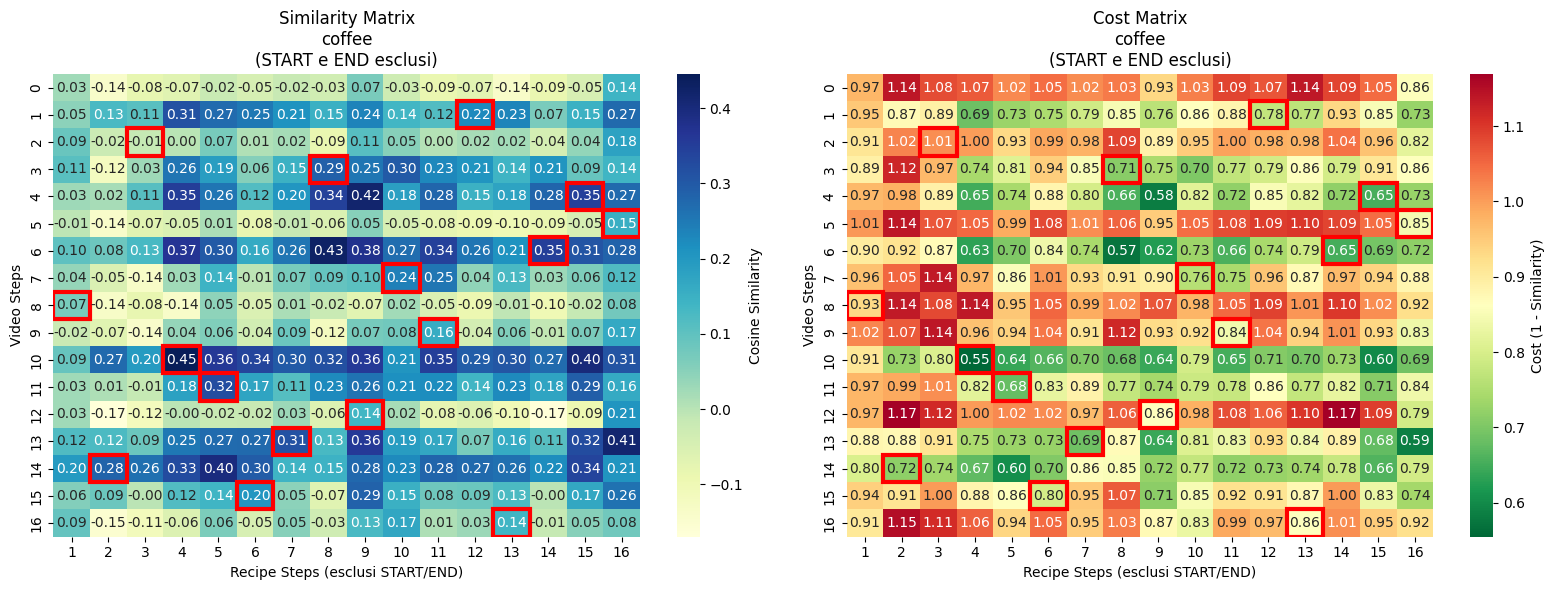

✅ Visualizzazione salvata in: /content/drive/MyDrive/MistakeDetection/hungarian_results
ℹ️  La matrice mostra solo gli step effettivi (START e END esclusi)
ℹ️  Indici asse X: da 1 a 16


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizza matrice di costo per un video specifico
if matching_results:
    test_video_id = list(matching_results.keys())[3]
    result = matching_results[test_video_id]

    # Ricalcola la matrice di costo per visualizzazione
    video_emb = video_features[test_video_id]
    recipe_emb_full = recipe_embeddings[result['recipe_name']]

    # ESCLUDI START e END (primo e ultimo step)
    recipe_emb = recipe_emb_full[1:-1]

    _, _, cost_matrix, _ = hungarian_matching(video_emb, recipe_emb)
    similarity_matrix = 1 - cost_matrix

    # Crea figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Preparazione delle etichette per l'asse x (indici incrementati di 1)
    recipe_steps_count = similarity_matrix.shape[1]
    x_labels = [str(i+1) for i in range(recipe_steps_count)]  # Indici da 1 a N

    # Plot 1: Matrice di similarità
    sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='YlGnBu',
                ax=ax1, cbar_kws={'label': 'Cosine Similarity'},
                xticklabels=x_labels, yticklabels=True)
    ax1.set_xlabel('Recipe Steps (esclusi START/END)')
    ax1.set_ylabel('Video Steps')
    ax1.set_title(f'Similarity Matrix\n{result["recipe_name"]}\n(START e END esclusi)')

    # Evidenzia i match selezionati dall'algoritmo ungherese
    # NOTA: recipe_idx è già 1-based nel risultato, quindi lo usiamo direttamente
    for video_idx, recipe_idx in result['matches']:
        # recipe_idx è già 1-based, quindi sottraiamo 1 per la posizione nella matrice
        # ma aggiungiamo 1 all'etichetta
        recipe_pos = recipe_idx - 1  # Torna a 0-based per la posizione nella matrice
        ax1.add_patch(plt.Rectangle((recipe_pos, video_idx), 1, 1,
                                     fill=False, edgecolor='red', lw=3))

    # Plot 2: Matrice di costo
    sns.heatmap(cost_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r',
                ax=ax2, cbar_kws={'label': 'Cost (1 - Similarity)'},
                xticklabels=x_labels, yticklabels=True)
    ax2.set_xlabel('Recipe Steps (esclusi START/END)')
    ax2.set_ylabel('Video Steps')
    ax2.set_title(f'Cost Matrix\n{result["recipe_name"]}\n(START e END esclusi)')

    # Evidenzia i match selezionati
    for video_idx, recipe_idx in result['matches']:
        recipe_pos = recipe_idx - 1  # Torna a 0-based per la posizione nella matrice
        ax2.add_patch(plt.Rectangle((recipe_pos, video_idx), 1, 1,
                                     fill=False, edgecolor='red', lw=3))

    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR) / f'hungarian_matching_{test_video_id}.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Visualizzazione salvata in: {OUTPUT_DIR}")
    print(f"ℹ️  La matrice mostra solo gli step effettivi (START e END esclusi)")
    print(f"ℹ️  Indici asse X: da 1 a {recipe_steps_count}")
else:
    print("⚠️ Nessun risultato di matching disponibile da visualizzare")

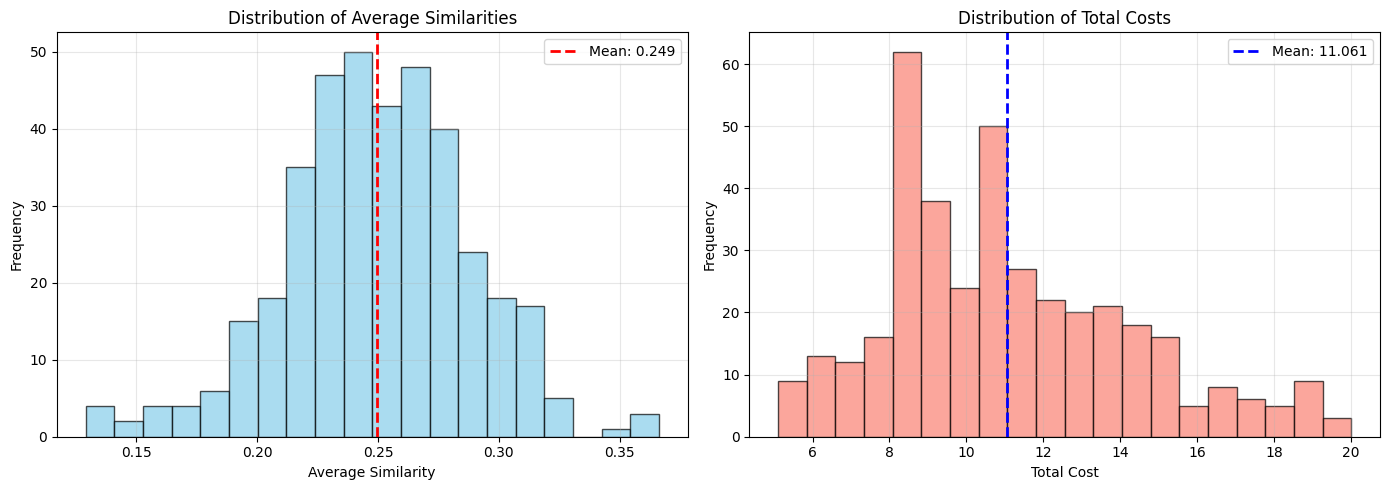

📊 STATISTICHE GLOBALI:
   Similarità media: 0.2495 ± 0.0383
   Similarità min/max: 0.1291 / 0.3661
   Costo medio: 11.0612 ± 3.1927
   Costo min/max: 5.1026 / 20.0088


In [20]:
# Statistiche globali sulla distribuzione delle similarità
if matching_results:
    all_similarities = [r['avg_similarity'] for r in matching_results.values()]
    all_costs = [r['total_cost'] for r in matching_results.values()]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Distribuzione similarità
    ax1.hist(all_similarities, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(all_similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_similarities):.3f}')
    ax1.set_xlabel('Average Similarity')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Average Similarities')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Plot 2: Distribuzione costi
    ax2.hist(all_costs, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    ax2.axvline(np.mean(all_costs), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_costs):.3f}')
    ax2.set_xlabel('Total Cost')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Total Costs')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(Path(OUTPUT_DIR) / 'hungarian_matching_statistics.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("📊 STATISTICHE GLOBALI:")
    print(f"   Similarità media: {np.mean(all_similarities):.4f} ± {np.std(all_similarities):.4f}")
    print(f"   Similarità min/max: {np.min(all_similarities):.4f} / {np.max(all_similarities):.4f}")
    print(f"   Costo medio: {np.mean(all_costs):.4f} ± {np.std(all_costs):.4f}")
    print(f"   Costo min/max: {np.min(all_costs):.4f} / {np.max(all_costs):.4f}")

In [21]:
# Salva i risultati in JSON
import json

output_file = Path(OUTPUT_DIR) / 'hungarian_matching_results_max_1_step.json'

# I recipe_steps sono già nel formato corretto (esclusi START/END)
results_to_save = {
    'statistics': statistics,
    'matching_results': matching_results,
    'config': {
        'video_features_path': VIDEO_FEATURES_PATH,
        'recipe_embeddings_dir': RECIPE_EMBEDDINGS_DIR,
        'annotation_json_path': ANNOTATION_JSON_PATH
    },
    'note': 'START (index 0) and END (last index) were EXCLUDED from matching. recipe_steps indices refer to actual recipe steps only (1 to N-2 in 0-based, or 1 to N-1 in 1-based where N is total including START/END)'
}

with open(output_file, 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"✅ Risultati salvati in: {output_file}")
print(f"   File size: {output_file.stat().st_size / 1024:.2f} KB")
print(f"   ⚠️ START e END esclusi dal matching")
print(f"   ℹ️  recipe_steps: indici degli step effettivi della ricetta")


✅ Risultati salvati in: /content/drive/MyDrive/MistakeDetection/hungarian_results/hungarian_matching_results_max_1_step.json
   File size: 560.22 KB
   ⚠️ START e END esclusi dal matching
   ℹ️  recipe_steps: indici degli step effettivi della ricetta


## 5. Sommario e Conclusioni

### 📋 Cosa fa questo notebook:

1. **Caricamento Dati**:
   - Carica video embeddings da `hiero_all_video_steps.npz` (384 video × 8 steps × 768 features)
   - Carica recipe embeddings da file `.pt` (24 ricette × N steps × 768 features)
   - Carica annotazioni JSON per mappare video → ricette

2. **Algoritmo Ungherese (Hungarian Algorithm)**:
   - Calcola matrice di similarità coseno tra video steps e recipe steps
   - Converte similarità in costi (cost = 1 - similarity)
   - Applica `scipy.optimize.linear_sum_assignment` per trovare l'assegnamento ottimale
   - Gestisce matrici non quadrate con padding

3. **Risultati**:
   - Matching ottimale per ogni video
   - Statistiche di performance (similarità media, costo totale)
   - Visualizzazioni con heatmap
   - Export risultati in JSON

### 🎯 Output generati:
- `hungarian_matching_results.json` - Tutti i risultati del matching
- `hungarian_matching_*.png` - Visualizzazioni delle matrici
- `hungarian_matching_statistics.png` - Statistiche globali

## 📝 Note sulla Rappresentazione degli Indici

**Nel JSON salvato:**
- **Video Steps**: 0-based (da 0 a 7) - rappresentano i cluster video
- **Recipe Steps**: Indici degli step effettivi della ricetta (START e END ESCLUSI dal matching)

**⚠️ IMPORTANTE:**
Gli embeddings delle ricette includono START ed END nel file `.pt`, ma l'algoritmo ungherese li **esclude automaticamente** usando solo `recipe_embeddings[1:-1]`. Gli indici `recipe_steps` nel JSON si riferiscono alla posizione nell'array completo (quindi 1 = primo step vero, non START).
